In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from dataloader import get_dataloaders
from models.msdnet import MSDNet
from utils import parse_args
from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict

import pandas as pd
import glob
import os
import shutil

from tqdm import tqdm
import pickle

sns.set_theme()

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(f'output/ImageNet.p', 'rb') as f:
    data = pickle.load(f)
logits, targets, ARGS = data

# 1 Anytime performance

In [3]:
L = len(logits)
N = logits.shape[1]

In [4]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [5]:
[round(float(x), 4) for x in acc]

[0.5663, 0.6514, 0.6842, 0.6977, 0.7134]

In [6]:
# probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.array([1. ,2., 3., 4., 5.])))
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.array([1. ,2., 3., 4., 5.]) / 5.) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [7]:
[round(float(x), 4) for x in acc_poe_ovr_break_ties_generalized]

[0.5663, 0.6508, 0.6867, 0.7022, 0.7138]

In [8]:
# probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.array([1. ,2., 3., 4., 5.])))
T = 2.
probs_poe_ovr_break_ties_generalized_tempered = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.array([1. ,2., 3., 4., 5.]) / 5.) * T))
preds_poe_ovr_break_ties_generalized_tempered = {i: torch.argmax(probs_poe_ovr_break_ties_generalized_tempered, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized_tempered = [(targets == preds_poe_ovr_break_ties_generalized_tempered[i]).sum() / len(targets) for i in range(L)]

# 2 Threshold criteria analysis

In [50]:
def msp_diff_top_k(_probs, l, N=N, top_k=5):
    scores = []
    for i in range(N):
        probs_i = _probs[l, i, :].numpy()
        score_i = (np.partition(probs_i.flatten(), -1)[-1] - np.partition(probs_i.flatten(), -top_k)[-top_k]) / (np.partition(probs_i.flatten(), -1)[-1])
        scores.append(score_i)
    return 1. - np.array(scores)

In [51]:
SCORES = ['ENTROPY', '1-MSP', 'PRED_SET_SIZE', '1-MSP-diff-topk']

thres_analysis_dict = {x: {} for x in SCORES}
for score in SCORES:
    preds_thres_crit_dict = {}
    preds_poe_ovr_thres_crit_dict = {}
    preds_thres_crit_metric = []
    preds_poe_ovr_thres_crit_metric = []
    preds_poe_ovr_tempered_thres_crit_metric = []
    for l in range(L):
        for _probs, _preds, _type in [(probs, preds, 'base'), 
                                    (probs_poe_ovr_break_ties_generalized, preds_poe_ovr_break_ties_generalized, 'PoE-OVR'),
                                    (probs_poe_ovr_break_ties_generalized_tempered, preds_poe_ovr_break_ties_generalized_tempered, 'PoE-OVR-tempered')]:
            if score == '1-MSP':
                scores = 1. - _probs[l].max(dim=1).values.numpy()
                rankings = scores.argsort()
            elif score == 'PRED_SET_SIZE':
                scores = (_probs[l] > 0).sum(axis=1)
                rankings = scores.argsort().numpy()
            elif score == 'ENTROPY':
                scores = scipy.stats.entropy(_probs[l].numpy(), axis=1)
                rankings = scores.argsort()
            elif score == '1-MSP-diff-topk':
                scores = msp_diff_top_k(_probs, l)
                rankings = scores.argsort()
            else:
                raise ValueError()
            preds_sorted = (_preds[l] == targets)[rankings].type(torch.uint8).numpy()

            thres_metric = np.subtract(preds_sorted.astype(float), np.sort(preds_sorted)[::-1].astype(float))
            thres_metric = (np.abs(thres_metric).sum() / N, (thres_metric == 1.).sum() / N)

            if _type == 'base':
                preds_thres_crit_dict[l] = (scores, rankings, preds_sorted)
                preds_thres_crit_metric.append(thres_metric)
            elif _type == 'PoE-OVR':
                preds_poe_ovr_thres_crit_dict[l] = (scores, rankings, preds_sorted)
                preds_poe_ovr_thres_crit_metric.append(thres_metric)
            elif _type == 'PoE-OVR-tempered':
                preds_poe_ovr_tempered_thres_crit_metric.append(thres_metric)
            else:
                raise ValueError()
    thres_analysis_dict[score] = {'base': (preds_thres_crit_dict, preds_thres_crit_metric),
                                  'PoE-OVR': (preds_poe_ovr_thres_crit_dict, preds_poe_ovr_thres_crit_metric),
                                  'PoE-OVR-tempered': (None, preds_poe_ovr_tempered_thres_crit_metric)}

In [52]:
# SCORE_TYPE = 'ENTROPY'
# SCORE_TYPE = '1-MSP'
# SCORE_TYPE = 'PRED_SET_SIZE'
SCORE_TYPE = '1-MSP-diff-topk'

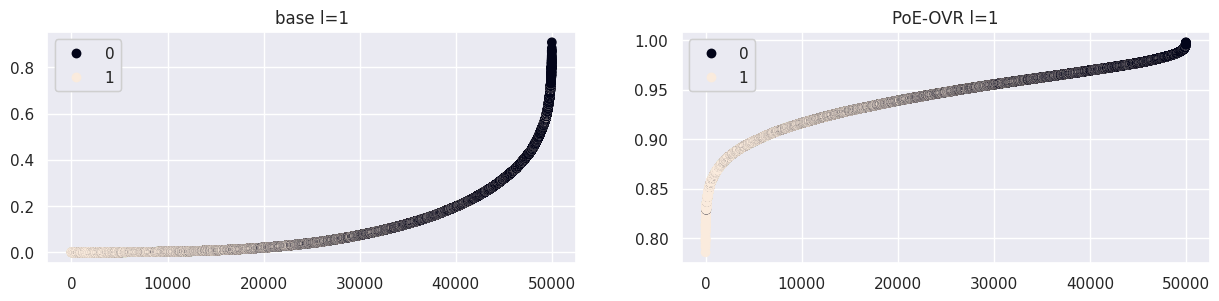

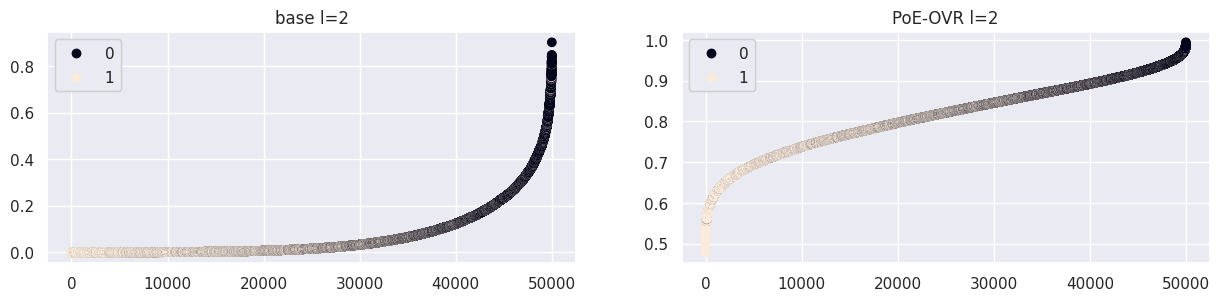

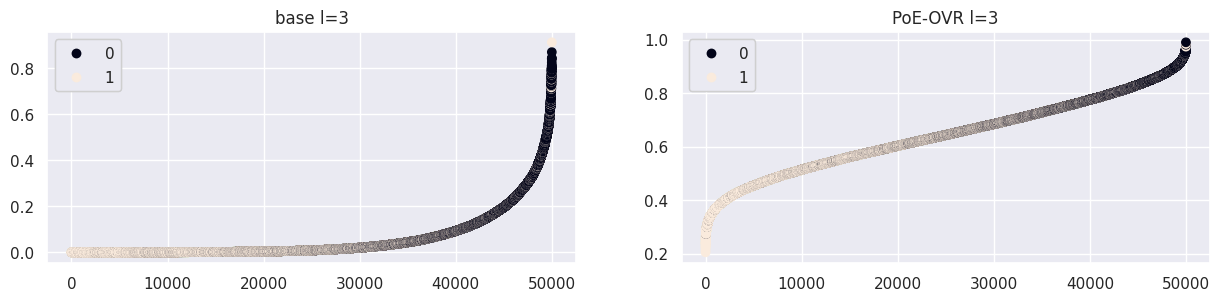

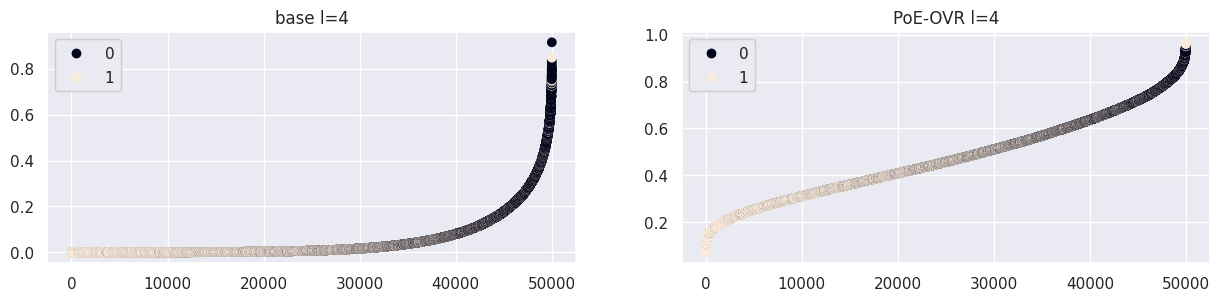

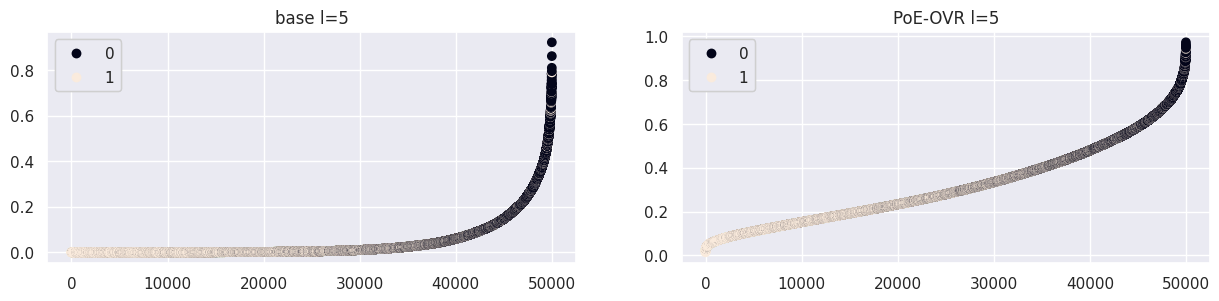

In [53]:
for l in range(L):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))

    base_dict = thres_analysis_dict[SCORE_TYPE]['base'][0]
    scatter = ax[0].scatter(np.arange(0, N, 1), base_dict[l][0][base_dict[l][1]], c=base_dict[l][2])
    legend = ax[0].legend(*scatter.legend_elements())
    ax[0].add_artist(legend)
    ax[0].set_title(f'base l={l + 1}')

    poe_ovr_dict = thres_analysis_dict[SCORE_TYPE]['PoE-OVR'][0]
    scatter = ax[1].scatter(np.arange(0, N, 1), poe_ovr_dict[l][0][poe_ovr_dict[l][1]], c=poe_ovr_dict[l][2])
    legend = ax[1].legend(*scatter.legend_elements())
    ax[1].add_artist(legend)
    ax[1].set_title(f'PoE-OVR l={l + 1}')
    
    plt.show()

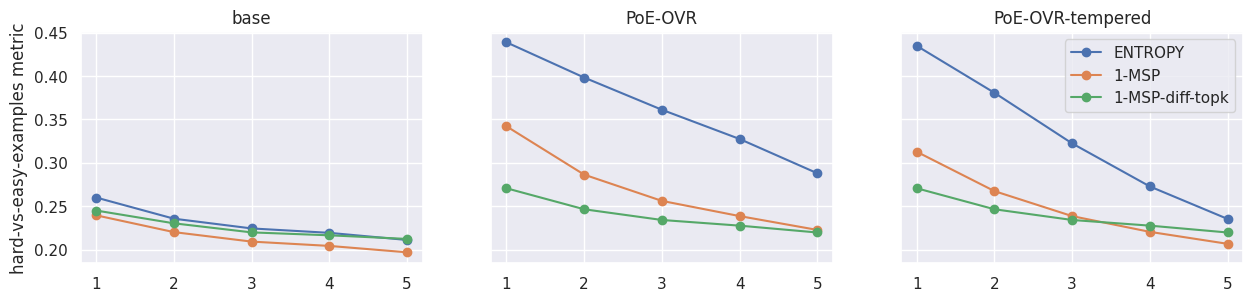

In [59]:
METRIC_TYPE = 0

fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharey=True, sharex=True)
for i, _model in enumerate(['base', 'PoE-OVR', 'PoE-OVR-tempered']):
    ax[i].set_title(_model)
    for score in SCORES:
        if score == 'PRED_SET_SIZE':
            continue
        ax[i].plot(np.arange(1, L + 1, 1), [x[METRIC_TYPE] for x in thres_analysis_dict[score][_model][1]], label=score, marker='o')
ax[0].set_ylabel('hard-vs-easy-examples metric')
plt.legend()
plt.show()

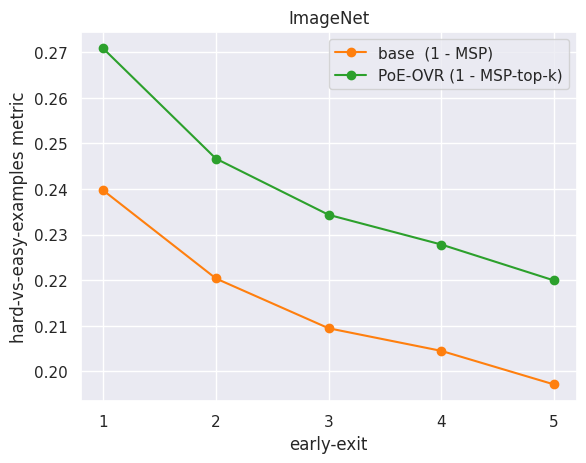

In [60]:
METRIC_TYPE = 0

plt.plot(np.arange(1, L + 1, 1), [x[METRIC_TYPE] for x in thres_analysis_dict['1-MSP']['base'][1]], label='base  (1 - MSP)', marker='o', color='tab:orange')
plt.plot(np.arange(1, L + 1, 1), [x[METRIC_TYPE] for x in thres_analysis_dict['1-MSP-diff-topk']['PoE-OVR'][1]], label='PoE-OVR (1 - MSP-top-k)', marker='o', color='tab:green')
# plt.plot(np.arange(1, L + 1, 1), [x[METRIC_TYPE] for x in thres_analysis_dict[SCORE_TYPE]['PoE-OVR-tempered'][1]], label='PoE-OVR-tempered', marker='o')
plt.xticks(np.arange(1, L + 1, 1))
plt.xlabel('early-exit')
plt.ylabel('hard-vs-easy-examples metric')
plt.title(f'{ARGS.data}')
plt.legend()

plt.show()

In [130]:
l=0
print(preds_thres_crit_dict[l][2][:100])
print(preds_poe_ovr_thres_crit_dict[l][2][:100])

i = 8
print(preds_poe_ovr_thres_crit_dict[l][1][i])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
8380


In [141]:
l = 0
j = 1134
# j = 8380

In [142]:
# both PoE-OvR and base got test example j=8380 wrong
preds_poe_ovr_thres_crit_dict[l][2][np.where(preds_poe_ovr_thres_crit_dict[l][1] == j)[0][0]], preds_thres_crit_dict[l][2][np.where(preds_thres_crit_dict[l][1] == j)[0][0]]

(1, 1)

In [143]:
# however, PoE-OvR put high MSP to it (8th largest MSP in the test set), while base put low MSP to it (only 24045th largest MSP in the test set)
np.where(preds_poe_ovr_thres_crit_dict[l][1] == j), np.where(preds_thres_crit_dict[l][1] == j)

((array([4]),), (array([5933]),))

In [144]:
# here is 1 - MSP for PoE-OvR and base
preds_poe_ovr_thres_crit_dict[l][0][j], preds_thres_crit_dict[l][0][j]

(0.99565446, 0.02848214)

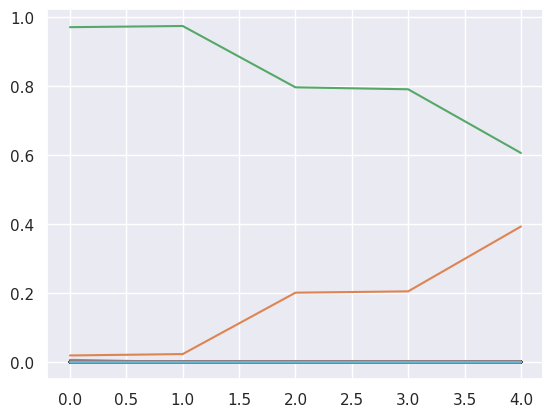

In [145]:
plt.plot(probs[:, j, :].numpy());

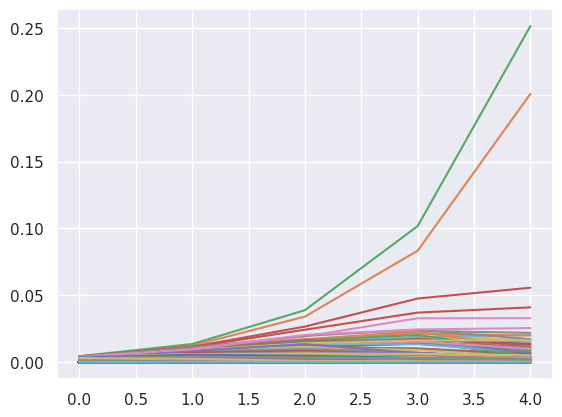

In [146]:
plt.plot(probs_poe_ovr_break_ties_generalized[:, j, :].numpy());

In [147]:
arr = probs_poe_ovr_break_ties_generalized[l, j, :].numpy()

In [148]:
arr.max()

0.0043455455

In [149]:
k = 2
np.partition(arr.flatten(), -2)[-2]

0.004224101

In [150]:
(np.partition(arr.flatten(), -1)[-1] - np.partition(arr.flatten(), -2)[-2]) / (np.partition(arr.flatten(), -1)[-1])

0.027946886

In [151]:
0.02794 / 0.002916

9.58161865569273

In [152]:
0.00434 / 0.00427

1.0163934426229508

In [21]:
def msp_diff_top_2(_probs, l, N=N):
    scores = []
    for i in range(N):
        probs_i = _probs[l, i, :].numpy()
        score_i = (np.partition(probs_i.flatten(), -1)[-1] - np.partition(probs_i.flatten(), -2)[-2]) / (np.partition(probs_i.flatten(), -1)[-1])
        scores.append(score_i)
    return 1. - np.array(scores)

In [23]:
probs[:, i, :]

tensor([[4.3495e-02, 1.1052e-05, 8.1150e-05,  ..., 1.1217e-05, 5.0709e-05,
         7.6444e-05],
        [9.8261e-03, 5.1419e-06, 6.8705e-06,  ..., 4.7689e-06, 5.2185e-05,
         1.4193e-04],
        [1.1445e-01, 1.2685e-05, 8.4880e-05,  ..., 8.3099e-06, 1.0636e-04,
         2.3611e-05],
        [7.8144e-02, 1.2166e-05, 3.9395e-05,  ..., 1.9823e-05, 3.2924e-04,
         6.3175e-06],
        [1.7128e-01, 2.1600e-05, 6.3915e-04,  ..., 3.3900e-05, 5.6570e-04,
         1.7394e-05]])

In [29]:
(msp_diff_top_2(probs, l=0)).min()

0.0

In [31]:
(msp_diff_top_2(probs_poe_ovr_break_ties_generalized, l=0))[0]

0.9798891

In [35]:
_sorted = probs_poe_ovr_break_ties_generalized[0, 0, :].sort().values.numpy()
1. - (_sorted[-1] - _sorted[-2]) / _sorted[-1]

0.9798891134560108